Źródła:
- https://nbviewer.jupyter.org/github/ogrisel/notebooks/blob/master/Labeled%20Faces%20in%20the%20Wild%20recognition.ipynb
- https://scikit-learn.org/0.18/auto_examples/applications/face_recognition.html

## Rozpoznawanie twarzy korzystając z SVM (Support-Vector Machine)

W tym przykładzie wytrenujemy własny model tak, aby przyporządkowywał imię do zdjęcia twarzy.
Skorzystamy z jednego ze zbiorów danych z modułu sklearn "Labeled Faces in the Wild".

Na początku pobieramy odpowiednie dane.

In [1]:
import pylab as pl
import numpy as np
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

x = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

n_samples, n_features = x.shape
_, h, w = lfw_people.images.shape
n_classes = len(names)

print(f"n_samples: {n_samples}")
print(f"n_features: {n_features}")
print(f"n_classes: {n_classes}")

n_samples: 1288
n_features: 1850
n_classes: 7


Jak widać, nasz zbiór danych nie jest mały.
Mamy wiele zdjęć przyporządkowanych do 7 osób.

Wyświetlmy część danych, aby mieć lepsze pojęcie, z czym mamy do czynienia.

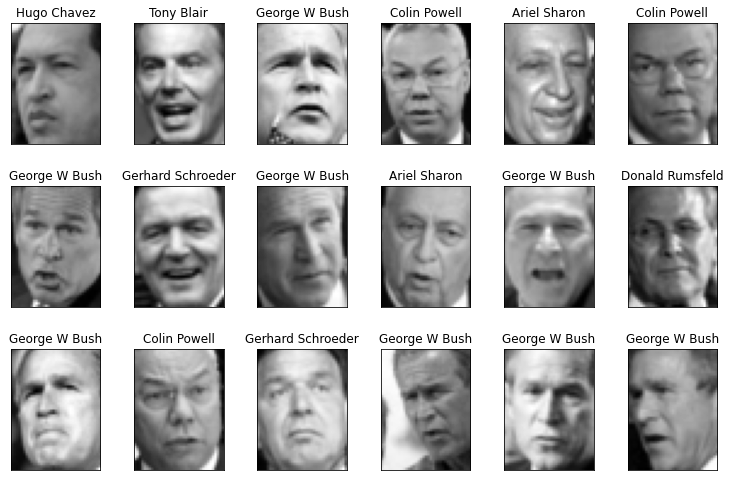

In [2]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    pl.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    pl.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.9, hspace=0.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

plot_gallery(x, names[y], h, w)

Przyjrzyjmy się dokładniej danym, z którymi mamy do czynienia.
Wiemy, że w zbiorze znajdują się zdjęcia twarzy różnych postaci.
Dla każdej osoby mamy co najmniej po kilkadziesiąt zdjęć.
Ile jednak dokładnie zdjęć jest dla konkretnych osób?
Czyja twarz występuje najczęściej?

Aby się tego dowiedzieć, stwórzmy wykres pokazujący, ile zdjęć jest przypisanych do danej osoby.
Wystarczy, że przeanalizujemy zbiór etykiet imion przyporządkowanych do zdjęć.

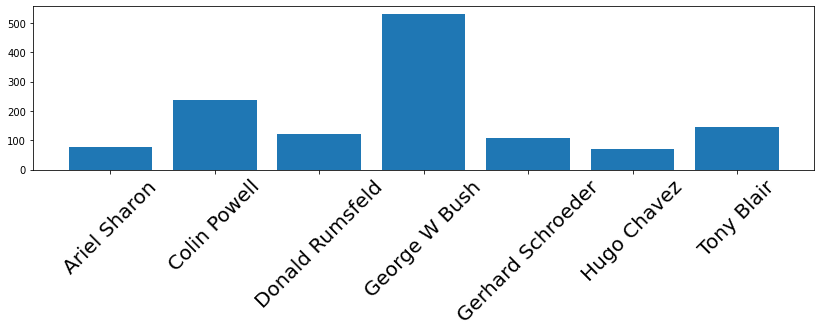

In [3]:
pl.figure(figsize=(14, 3))

y_unique = np.unique(y)
counts = [(y == i).sum() for i in y_unique]

pl.xticks(y_unique,  names[y_unique])
locs, labels = pl.xticks()
pl.setp(labels, rotation=45, size=20)
_ = pl.bar(y_unique, counts)

Naszym celem jest takie wytrenowanie naszego narzędzia, żeby poprawnie rozpoznawało osoby na zdjęciu.
W tym celu będą nam potrzebne odpowiednie dane treningowe.
Poza tym potrzebujemy także zbioru, na którym będziemy testować skuteczność naszego narzędzia.
W tym celu dzielimy dane na dwa zbiory: zbiór do testowy i zbiór treningowy.

In [4]:
from sklearn.model_selection  import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

Zanim przejdziemy do trenowania naszego modelu, musimy odpowiednio przygotować dane.
Jednym ze sposobów na radzenie sobie ze zdjęciami przedstawiającymi twarze, jest przygotowanie tzw. eigenfaces.

W tym celu skorzystamy z modułu PCA.

In [5]:
from sklearn.decomposition import PCA

n_components = 150
pca = PCA(n_components=n_components, whiten=True)

%time pca.fit(x_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

Wall time: 523 ms


Przygotowaliśmy dane, zobaczmy teraz jak one wyglądają.

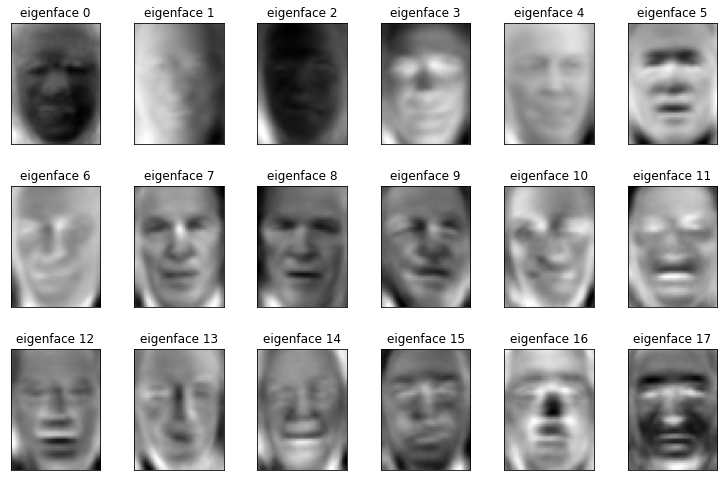

In [6]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

Teraz przygotowujemy dane treningowe i testowe.

In [7]:
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

Wreszcie przyszła pora na przygotowanie naszego klasyfikatora SVC (Support-Vector Clustering).

In [8]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", class_weight="auto")

Zanim będziemy mogli użyć go do sklasyfikowania naszych zdjęć, musimy wykonać dwie czynności:
dobrać odpowiednie parametry i przeszkolić model na danych treningowych.

Niestety, domyślnie parametry zazwyczaj nie dadzą satysfakcjonujących rezultatów.
Znalezienie dobrych parametrów wymaga skorzystania z odpowiednich narzędzi, a często także z metody prób i błędów.

In [9]:
from sklearn.model_selection import GridSearchCV
print("Fitting the classifier to the training set")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(x_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


Nauka skończona, przejdźmy do predykcji.
Sprawdźmy działanie naszego modelu na danych testowych.

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
print("Predicting people's names on the test set")
y_pred = clf.predict(x_test_pca)

print(classification_report(y_test, y_pred, target_names=names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.44      0.58        16
     Colin Powell       0.81      0.89      0.85        56
  Donald Rumsfeld       0.80      0.71      0.75        28
    George W Bush       0.81      0.98      0.89       134
Gerhard Schroeder       0.96      0.76      0.85        29
      Hugo Chavez       1.00      0.47      0.64        17
       Tony Blair       0.94      0.79      0.86        42

         accuracy                           0.84       322
        macro avg       0.88      0.72      0.77       322
     weighted avg       0.85      0.84      0.83       322

[[  7   4   1   4   0   0   0]
 [  1  50   0   5   0   0   0]
 [  0   1  20   6   1   0   0]
 [  0   2   1 131   0   0   0]
 [  0   1   2   3  22   0   1]
 [  0   3   0   5   0   8   1]
 [  0   1   1   7   0   0  33]]


Jak pokazują powyższe statystyki, nasze narzędzie sprawuje się całkiem dobrze.

Zobaczmy, jak to wygląda na konkretnych zdjęciach.

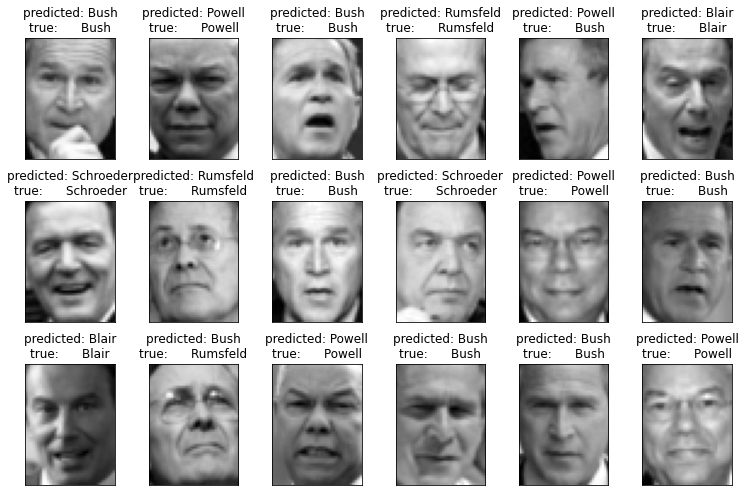

In [11]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(x_test, prediction_titles, h, w)